In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%cd /content/drive/MyDrive/Independent\ Study/fingerprints

/content/drive/MyDrive/Independent Study/fingerprints


In [24]:
import pandas as pd
df = pd.read_csv('top_1000_high_disagreement_samples.csv')
df.head()

,Unnamed: 0,label,ending0,ending1,ending2,ending3,qwen_0.5b_pred,qwen_0.5b_correct,qwen_1.5b_pred,qwen_1.5b_correct,...,phi3_mini_pred,phi3_mini_correct,sailor2_1b_pred,sailor2_1b_correct,llama3.2_1b_pred,llama3.2_1b_correct,llama3_8b_pred,llama3_8b_correct,gemma2_9b_pred,gemma2_9b_correct
0,8449,2,Reshape your hands after 10 and 20 drops of du...,Place the fingers of your two hands on the sid...,Do this to avoid painful application of the du...,Remove it from the lamp until you feel relief ...,3,False,1,False,...,2,True,3,False,-2,False,-2,False,0,False
1,8055,1,This oval should form a circle in the bottom e...,Click and hold the circle and tap on create oval,While still selected click on the orange color,This is the body of the ladybug,1,True,3,False,...,2,False,0,False,2,False,1,True,0,False
2,5636,3,Speak in a firm voice that focuses the convers...,This is a good way to keep distance between yo...,For example i am a fragile person,this statement will help take the focus off of...,1,False,2,False,...,3,True,-2,False,3,True,2,False,3,True
3,5037,1,Because the plaintiff waited for permission to...,Because you used obscene or hazardous material...,note that this intrusion does not need to be p...,the invasion would be offensive to a reasonabl...,0,False,2,False,...,-2,False,2,False,0,False,0,False,3,False
4,5103,3,Think about defining the two dividencies and s...,Doing this may help you organize the problem s...,Do the same with all the dividend bars includi...,Make a formula to solve the problem,0,False,2,False,...,1,False,0,False,0,False,0,False,2,False


# Approach 1: Confusion Matrix Fingerprinting

This approach treats each model's confusion matrix as a unique "fingerprint"

that captures its systematic error patterns and prediction behavior.

## Key Concepts:

*   **Fingerprint**: 16-dimensional vector from flattened 4×4 confusion matrix
*   **Identification Method**: Cosine similarity matching
*   **Goal**: Identify which model produced a set of predictions

---


**Cell 1 – Setup and Imports**

Initializes the Python environment, imports all required numerical, machine learning,

and visualization libraries, and suppresses non-critical warnings to keep logs clean.

In [25]:
# Purpose: Import required libraries and configure the runtime environment.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


**Cell 2 – Load Data and Extract Model Information**

Automatically discovers all evaluated models by scanning prediction columns and

prints a concise dataset summary. This avoids hardcoding model names and ensures

scalability to larger model sets.

In [26]:
# Purpose: Identify model prediction columns and summarize dataset structure.

# Assuming df is already loaded

# df = pd.read_csv('your_dataset.csv')

# Extract all model names from columns

pred_cols = [col for col in df.columns if col.endswith('_pred')]
model_names = [col.replace('_pred', '') for col in pred_cols]

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total samples: {len(df)}")
print(f"Number of models: {len(model_names)}")
print(f"\nModels found:")
for i, name in enumerate(model_names, 1):
    print(f"  {i:2d}. {name}")
print()

DATASET OVERVIEW
Total samples: 1000
Number of models: 22

Models found:
   1. qwen_0.5b
   2. qwen_1.5b
   3. qwen_7b
   4. stable_zephyr_3b
   5. stable2_1.6b
   6. stable2_12b
   7. qwen2_7b
   8. neural-chat_7b
   9. codegemma_7b
  10. openchat_7b
  11. mistral_7b
  12. phi3_medium
  13. dolphin-llama3_8b
  14. yi_9b
  15. yi_6b
  16. gemma3_1b
  17. llama3.1_8b
  18. phi3_mini
  19. sailor2_1b
  20. llama3.2_1b
  21. llama3_8b
  22. gemma2_9b



**Cell 3 – Data Quality Check**

Validates prediction ranges for each model, quantifies invalid outputs, and reports

per-model data hygiene to prevent corrupted or misleading fingerprints.

In [27]:
# Purpose: Verify prediction validity and quantify invalid label occurrences.

# Create model prediction columns dictionary

model_pred_cols = {name: f"{name}_pred" for name in model_names}
model_correct_cols = {name: f"{name}_correct" for name in model_names}

n_classes = 4

print("=" * 80)
print("DATA QUALITY CHECK")
print("=" * 80)
print(f"{'Model':<30s} {'Invalid':<10s} {'Valid':<10s} {'Invalid %':<10s}")
print("-" * 80)

quality_report = []
for name in model_names:
    col = model_pred_cols[name]
    n_invalid = ((df[col] < 0) | (df[col] >= n_classes)).sum()
    n_valid = len(df) - n_invalid
    pct_invalid = 100 * n_invalid / len(df)
    quality_report.append({
        'model': name,
        'invalid': n_invalid,
        'valid': n_valid,
        'pct_invalid': pct_invalid
    })
    print(f"{name:<30s} {n_invalid:<10d} {n_valid:<10d} {pct_invalid:<10.2f}%")

print()

DATA QUALITY CHECK
Model                          Invalid    Valid      Invalid % 
--------------------------------------------------------------------------------
qwen_0.5b                      0          1000       0.00      %
qwen_1.5b                      1          999        0.10      %
qwen_7b                        0          1000       0.00      %
stable_zephyr_3b               1          999        0.10      %
stable2_1.6b                   533        467        53.30     %
stable2_12b                    184        816        18.40     %
qwen2_7b                       4          996        0.40      %
neural-chat_7b                 135        865        13.50     %
codegemma_7b                   0          1000       0.00      %
openchat_7b                    0          1000       0.00      %
mistral_7b                     150        850        15.00     %
phi3_medium                    539        461        53.90     %
dolphin-llama3_8b              50         950        5.0

**Cell 4 – Train/Test Split**

Splits the dataset into disjoint training and test partitions. Fingerprints are

constructed exclusively on the training set to prevent information leakage during

identification evaluation.

In [28]:
# Purpose: Partition data to prevent fingerprint leakage during evaluation.

print("=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)

# Split data into train (80%) and test (20%) sets

# IMPORTANT: We'll compute fingerprints ONLY on training data to avoid leakage

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print()

TRAIN/TEST SPLIT
Training set size: 800
Test set size: 200



**Cell 5 – Confusion Matrix Fingerprinting Function**

Defines the core fingerprint primitive: a normalized confusion histogram that captures

systematic prediction tendencies and structured error behavior for each model.

In [29]:
# Purpose: Define the core transformation from predictions to fingerprint vectors.

def confusion_hist(gold_labels, pred_labels, n_classes=4):
    """
    Compute a confusion matrix and return it as a normalized histogram.
    This creates a 'fingerprint' of a model's error patterns.

    Args:
        gold_labels: Ground truth labels
        pred_labels: Model predictions
        n_classes: Number of classes (4 for HellaSwag)

    Returns:
        v: Flattened, normalized confusion histogram (16-d for 4 classes)
        conf: Raw confusion matrix (4x4)
    """
    # Initialize confusion matrix
    conf = np.zeros((n_classes, n_classes), dtype=np.int64)

    # Populate confusion matrix
    # conf[i,j] = number of times true label was i and prediction was j
    for g, p in zip(gold_labels, pred_labels):
        if 0 <= g < n_classes and 0 <= p < n_classes:
            conf[g, p] += 1

    # Flatten and normalize to create a probability distribution
    v = conf.flatten().astype(np.float32)
    v /= v.sum() + 1e-8  # Add epsilon to avoid division by zero

    return v, conf

print("✓ Confusion fingerprinting function defined")

✓ Confusion fingerprinting function defined


**Cell 6 – Compute Model Fingerprints**

Computes one reference fingerprint per model using only training data and reports

baseline accuracies to contextualize fingerprint quality.

In [30]:
# Purpose: Generate reference fingerprints for each model using training data.

print("=" * 80)
print("COMPUTING MODEL FINGERPRINTS")
print("=" * 80)
print("(Using training data only to avoid leakage)\n")

train_gold = train_df["label"].to_numpy()

fingerprints = {}  # Normalized 16-d vectors
conf_mats = {}     # Raw 4x4 confusion matrices

for name in model_names:
    col = model_pred_cols[name]
    train_pred = train_df[col].to_numpy()

    v, cm = confusion_hist(train_gold, train_pred, n_classes)
    fingerprints[name] = v
    conf_mats[name] = cm

    acc = cm.diagonal().sum() / cm.sum() if cm.sum() > 0 else 0
    print(f"{name:<30s} Accuracy: {acc:.3f}")

print(f"\n✓ Fingerprints computed for {len(fingerprints)} models")
print()

COMPUTING MODEL FINGERPRINTS
(Using training data only to avoid leakage)

qwen_0.5b                      Accuracy: 0.268
qwen_1.5b                      Accuracy: 0.218
qwen_7b                        Accuracy: 0.287
stable_zephyr_3b               Accuracy: 0.253
stable2_1.6b                   Accuracy: 0.231
stable2_12b                    Accuracy: 0.255
qwen2_7b                       Accuracy: 0.263
neural-chat_7b                 Accuracy: 0.266
codegemma_7b                   Accuracy: 0.273
openchat_7b                    Accuracy: 0.250
mistral_7b                     Accuracy: 0.214
phi3_medium                    Accuracy: 0.243
dolphin-llama3_8b              Accuracy: 0.243
yi_9b                          Accuracy: 0.244
yi_6b                          Accuracy: 0.249
gemma3_1b                      Accuracy: 0.217
llama3.1_8b                    Accuracy: 0.240
phi3_mini                      Accuracy: 0.234
sailor2_1b                     Accuracy: 0.219
llama3.2_1b                    Ac

**Cell 7 – Visualize Individual Confusion Matrices**

Displays normalized confusion matrices for a subset of models to enable qualitative

inspection of model-specific error patterns.

VISUALIZING CONFUSION MATRICES
✓ Saved: confusion_matrices_sample.png


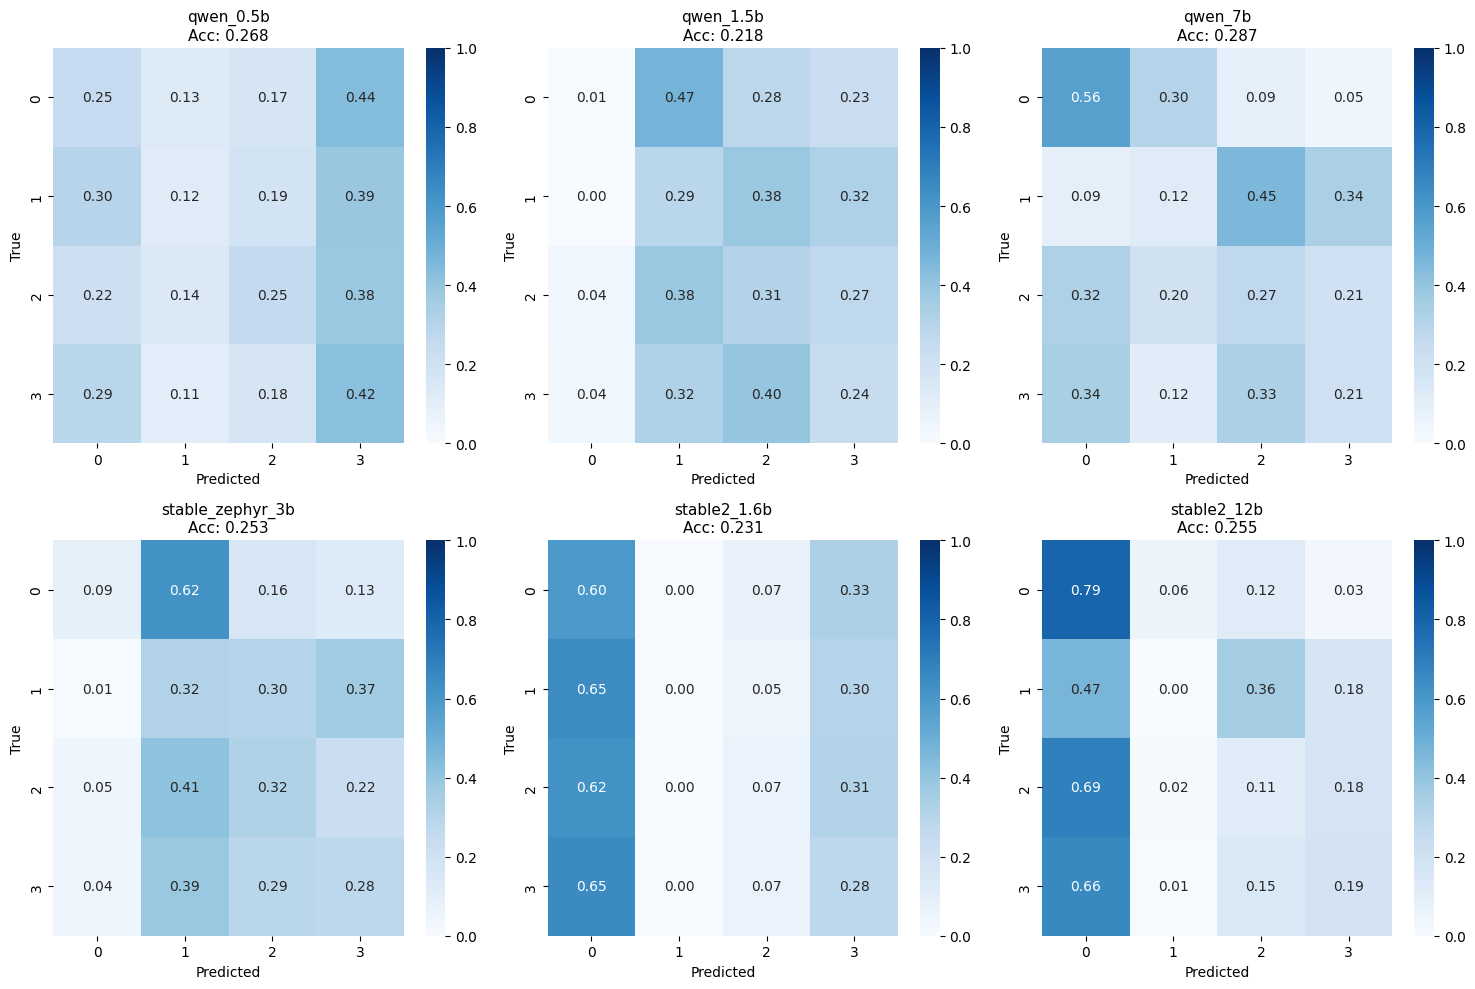

In [31]:
# Purpose: Qualitatively inspect per-model error patterns.

print("=" * 80)
print("VISUALIZING CONFUSION MATRICES")
print("=" * 80)

# Show first 6 models as example

n_display = min(6, len(model_names))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, name in enumerate(model_names[:n_display]):
    cm = conf_mats[name]

    # Normalize by row (true label) to show distribution of predictions
    cm_norm = cm.astype(float)
    row_sums = cm_norm.sum(axis=1, keepdims=True)
    cm_norm = cm_norm / (row_sums + 1e-8)

    ax = axes[idx]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                ax=ax, cbar=True, vmin=0, vmax=1)

    acc = cm.diagonal().sum()/cm.sum() if cm.sum() > 0 else 0
    ax.set_title(f'{name}\nAcc: {acc:.3f}', fontsize=11)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices_sample.png', dpi=150, bbox_inches='tight')
print("✓ Saved: confusion_matrices_sample.png")
plt.show()

**Cell 8 – Complete Confusion Matrix Grid**

Visualizes confusion matrices for all models simultaneously, facilitating comparison

and revealing structural similarities across model families.

✓ Saved: confusion_matrices_all.png


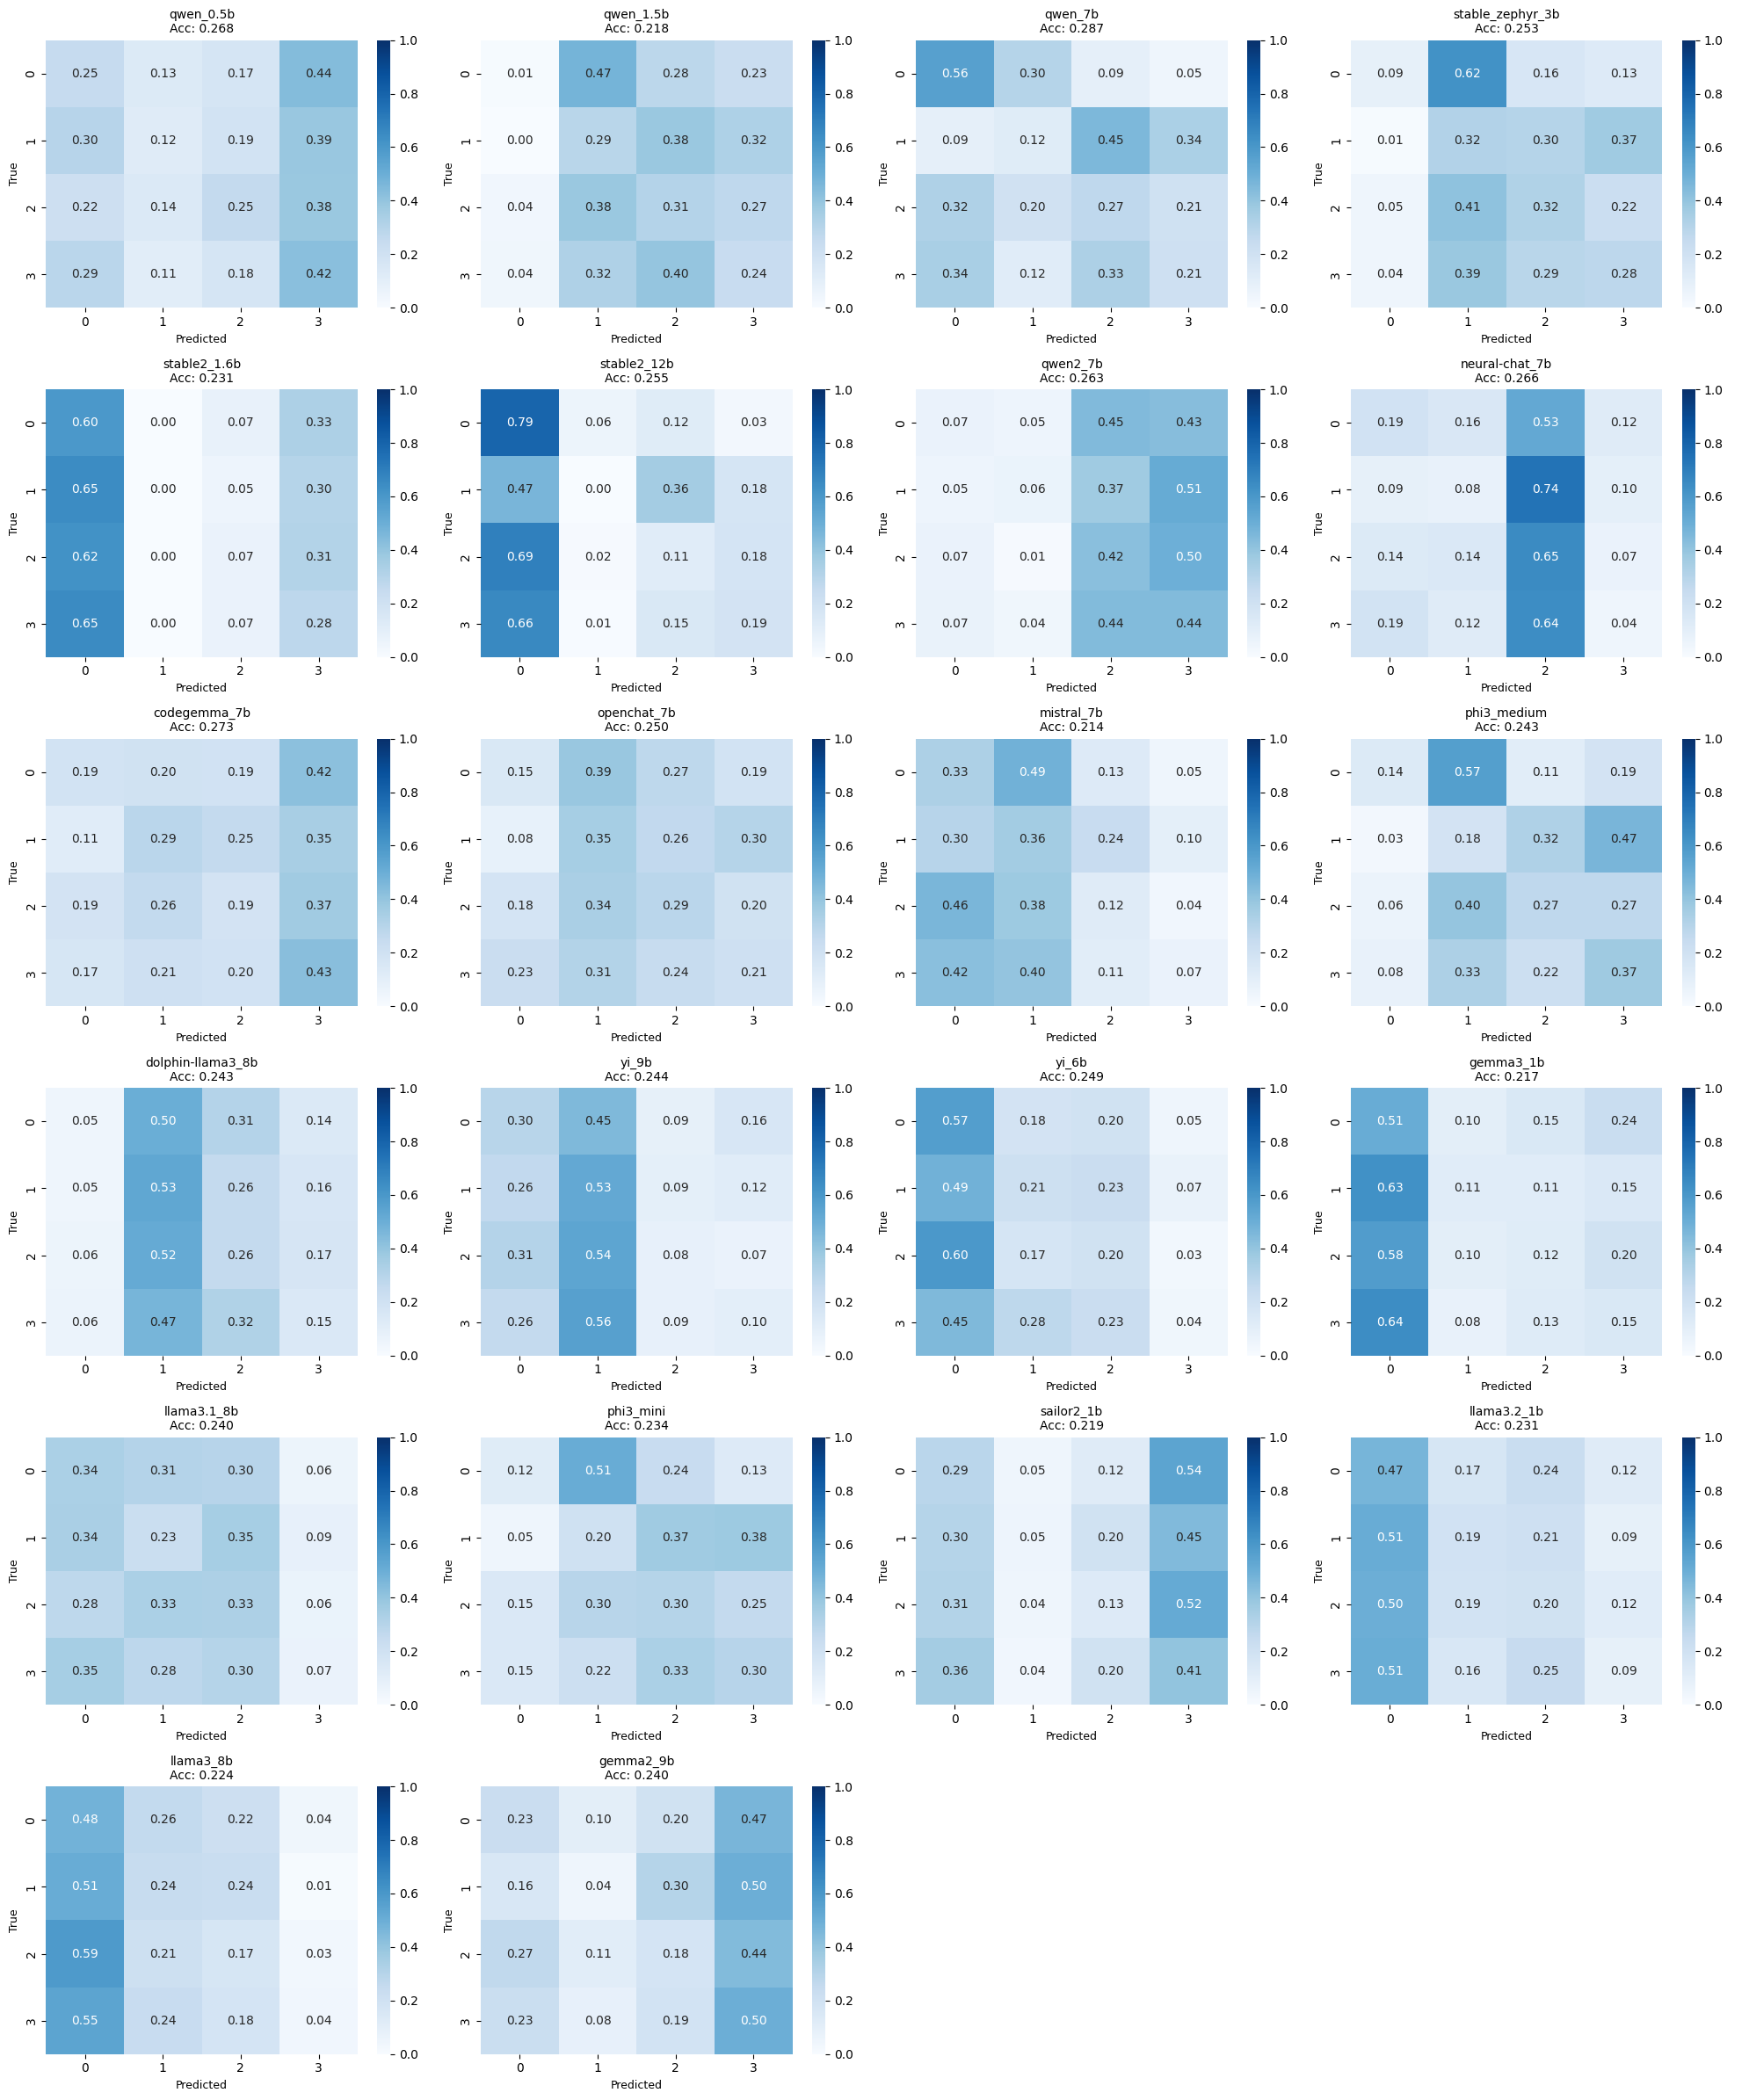

In [32]:
# Purpose: Visualize confusion matrices for all models at once.

n_models = len(model_names)
n_cols = 4
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, name in enumerate(model_names):
    cm = conf_mats[name]

    # Normalize by row
    cm_norm = cm.astype(float)
    row_sums = cm_norm.sum(axis=1, keepdims=True)
    cm_norm = cm_norm / (row_sums + 1e-8)

    ax = axes[idx]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                ax=ax, cbar=True, vmin=0, vmax=1)

    acc = cm.diagonal().sum()/cm.sum() if cm.sum() > 0 else 0
    ax.set_title(f'{name}\nAcc: {acc:.3f}', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=9)
    ax.set_ylabel('True', fontsize=9)

# Hide unused subplots

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices_all.png', dpi=150, bbox_inches='tight')
print("✓ Saved: confusion_matrices_all.png")
plt.show()

**Cell 9 – Fingerprint Similarity Analysis**

Computes pairwise cosine similarity between fingerprints to quantify behavioral

proximity and divergence among models.

FINGERPRINT SIMILARITY ANALYSIS

Most Similar Model Pairs:
  yi_6b <-> llama3_8b: 0.9884
  llama3.2_1b <-> llama3_8b: 0.9817
  yi_6b <-> llama3.2_1b: 0.9803
  qwen_0.5b <-> gemma2_9b: 0.9730
  qwen_1.5b <-> stable_zephyr_3b: 0.9725

Most Different Model Pairs:
  qwen_1.5b <-> stable2_12b: 0.3118
  stable_zephyr_3b <-> stable2_1.6b: 0.2947
  qwen_1.5b <-> stable2_1.6b: 0.2919
  stable2_12b <-> dolphin-llama3_8b: 0.2701
  stable2_1.6b <-> dolphin-llama3_8b: 0.2344

✓ Saved: fingerprint_similarity.png


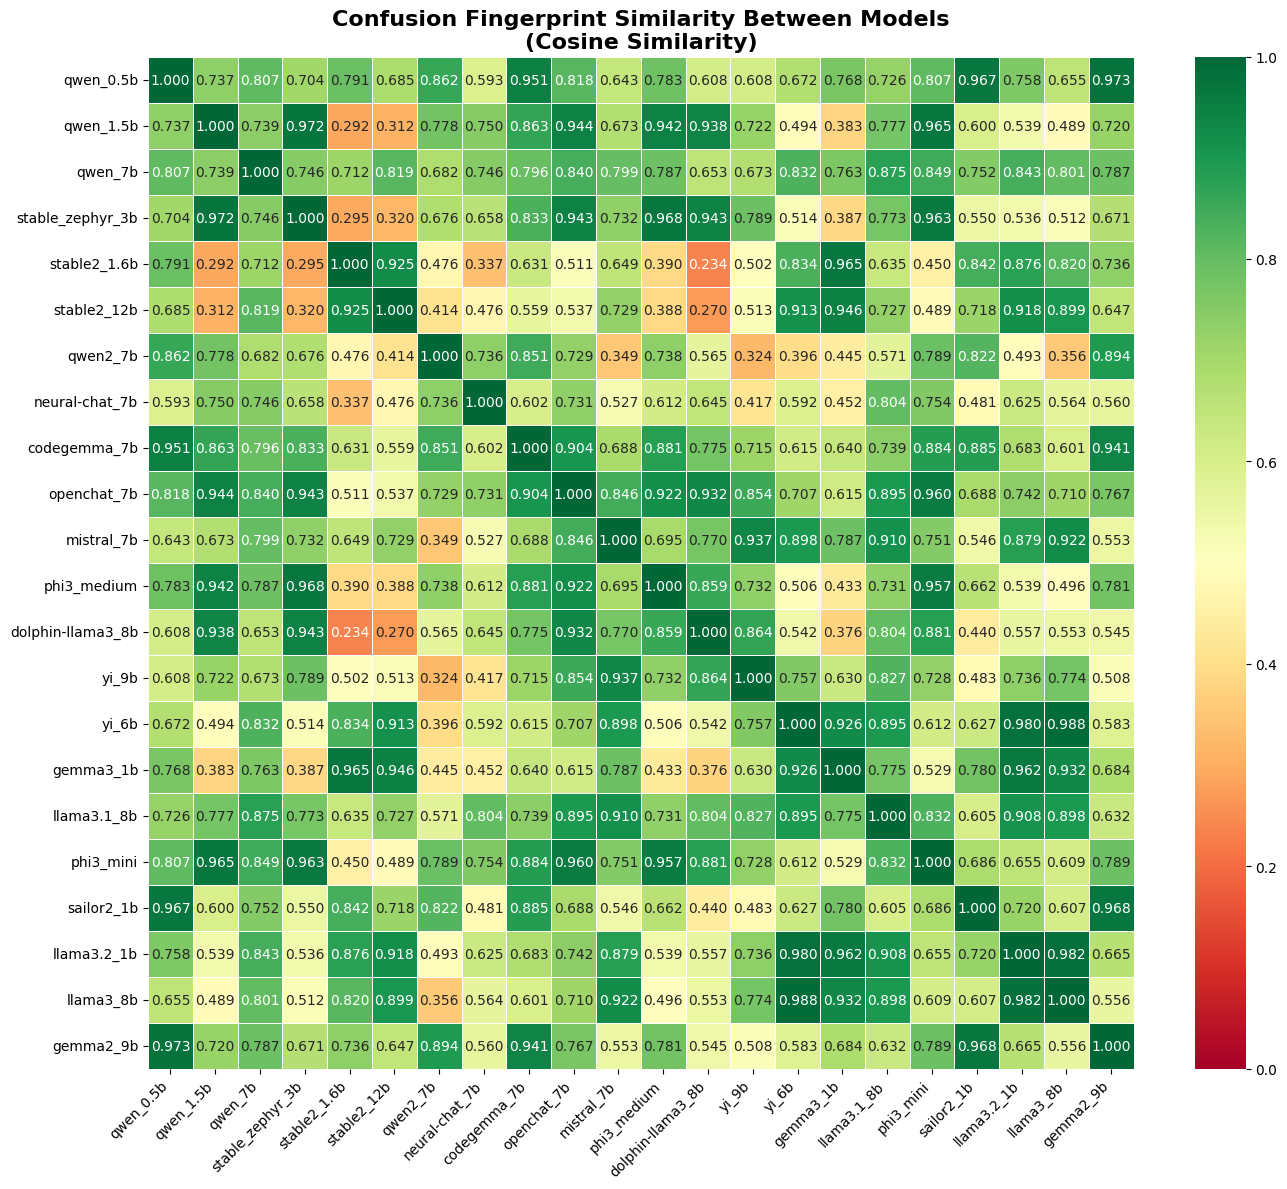

In [33]:
# Purpose: Quantify similarity between model fingerprints via cosine similarity.

print("=" * 80)
print("FINGERPRINT SIMILARITY ANALYSIS")
print("=" * 80)

# Stack all reference fingerprints into a matrix

family_matrix = np.stack([fingerprints[name] for name in model_names])

# Compute pairwise cosine similarities

similarity_matrix = cosine_similarity(family_matrix)

# Find most similar and most different pairs

sim_pairs = []
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        sim_pairs.append((model_names[i], model_names[j], similarity_matrix[i, j]))

sim_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nMost Similar Model Pairs:")
for name1, name2, sim in sim_pairs[:5]:
    print(f"  {name1} <-> {name2}: {sim:.4f}")

print("\nMost Different Model Pairs:")
for name1, name2, sim in sim_pairs[-5:]:
    print(f"  {name1} <-> {name2}: {sim:.4f}")

print()

# Visualize similarity matrix

plt.figure(figsize=(14, 12))
sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=model_names, yticklabels=model_names,
            vmin=0, vmax=1, center=0.5, linewidths=0.5)
plt.title('Confusion Fingerprint Similarity Between Models\n(Cosine Similarity)',
          fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('fingerprint_similarity.png', dpi=150, bbox_inches='tight')
print("✓ Saved: fingerprint_similarity.png")
plt.show()

**Cell 10 – Model Identification System**

Implements the inference-time identification procedure that matches unknown prediction

sets to the closest reference fingerprint.

In [34]:
# Purpose: Define the inference-time model identification procedure.

print("=" * 80)
print("MODEL IDENTIFICATION SYSTEM")
print("=" * 80)

# Get test set ground truth

test_gold = test_df["label"].to_numpy()

def identify_family(sub_gold, sub_pred):
    """
    Identify which model family produced these predictions.

    Method:
    1. Compute confusion fingerprint for the subset
    2. Calculate cosine similarity with each reference fingerprint
    3. Return the model with highest similarity
    """
    v, _ = confusion_hist(sub_gold, sub_pred, n_classes)
    v = v.reshape(1, -1)

    # Compute cosine similarity with each reference fingerprint
    sims = cosine_similarity(v, family_matrix)[0]
    best_idx = np.argmax(sims)

    return model_names[best_idx], sims

print("✓ Model identification system ready")
print()

MODEL IDENTIFICATION SYSTEM
✓ Model identification system ready



**Cell 11 – Single-Model Identification Demonstration**

Demonstrates identification behavior as a function of probe size using a fixed target

model to illustrate robustness under limited observations.

In [35]:
# Purpose: Demonstrate identification behavior as probe size increases.

print("Testing identification with different probe sizes...\n")

test_model = model_names[0]
test_col = model_pred_cols[test_model]
test_pred = test_df[test_col].to_numpy()

# Test with increasing probe sizes

for n_probe in [5, 10, 20, 50, 100]:
    if n_probe <= len(test_df):
        idx = np.random.choice(len(test_df), size=n_probe, replace=False)
        sub_gold = test_gold[idx]
        sub_pred = test_pred[idx]

        identified, sims = identify_family(sub_gold, sub_pred)

        print(f"With {n_probe:3d} probes from {test_model}:")
        print(f"  Identified as: {identified}")
        print(f"  Correct: {identified == test_model}")
        print(f"  Confidence: {sims.max():.4f}")
        print()

Testing identification with different probe sizes...

With   5 probes from qwen_0.5b:
  Identified as: llama3.1_8b
  Correct: False
  Confidence: 0.5523

With  10 probes from qwen_0.5b:
  Identified as: qwen_0.5b
  Correct: True
  Confidence: 0.6485

With  20 probes from qwen_0.5b:
  Identified as: codegemma_7b
  Correct: False
  Confidence: 0.8275

With  50 probes from qwen_0.5b:
  Identified as: codegemma_7b
  Correct: False
  Confidence: 0.8829

With 100 probes from qwen_0.5b:
  Identified as: codegemma_7b
  Correct: False
  Confidence: 0.9081



**Cell 12 – Comprehensive Probe Size Experiments**

Systematically evaluates identification accuracy across probe sizes and random trials

to estimate sample complexity for reliable model identification.

In [36]:
# Purpose: Systematically evaluate identification accuracy vs. probe size.

print("=" * 80)
print("PROBE SIZE EXPERIMENTS")
print("=" * 80)
print("Evaluating identification accuracy vs. probe set size...\n")

rng = np.random.default_rng(42)

def eval_probe_size(model_name, n_probe=20, n_trials=100):
    """
    Evaluate how many samples are needed to identify a model.
    """
    correct = 0
    col = model_pred_cols[model_name]
    full_test_pred = test_df[col].to_numpy()
    n_items_test = len(test_df)

    for _ in range(n_trials):
        # Sample random subset of test predictions
        idx = rng.choice(n_items_test, size=min(n_probe, n_items_test), replace=False)
        sub_gold = test_gold[idx]
        sub_pred = full_test_pred[idx]

        # Identify model based on this subset
        identified_family, _ = identify_family(sub_gold, sub_pred)
        if identified_family == model_name:
            correct += 1

    return correct / n_trials

# Test various probe sizes

probe_sizes = [5, 10, 20, 50, 100]
results = {}

for model_name in model_names:
    results[model_name] = []
    print(f"{model_name}:")

    for n_probe in probe_sizes:
        acc = eval_probe_size(model_name, n_probe=n_probe, n_trials=100)
        results[model_name].append(acc)
        print(f"  {n_probe:3d} probes: {acc:.3f} accuracy")
    print()

PROBE SIZE EXPERIMENTS
Evaluating identification accuracy vs. probe set size...

qwen_0.5b:
    5 probes: 0.090 accuracy
   10 probes: 0.170 accuracy
   20 probes: 0.410 accuracy
   50 probes: 0.710 accuracy
  100 probes: 0.920 accuracy

qwen_1.5b:
    5 probes: 0.070 accuracy
   10 probes: 0.170 accuracy
   20 probes: 0.440 accuracy
   50 probes: 0.840 accuracy
  100 probes: 0.990 accuracy

qwen_7b:
    5 probes: 0.250 accuracy
   10 probes: 0.350 accuracy
   20 probes: 0.720 accuracy
   50 probes: 0.960 accuracy
  100 probes: 1.000 accuracy

stable_zephyr_3b:
    5 probes: 0.090 accuracy
   10 probes: 0.160 accuracy
   20 probes: 0.220 accuracy
   50 probes: 0.300 accuracy
  100 probes: 0.530 accuracy

stable2_1.6b:
    5 probes: 0.220 accuracy
   10 probes: 0.340 accuracy
   20 probes: 0.620 accuracy
   50 probes: 0.870 accuracy
  100 probes: 0.990 accuracy

stable2_12b:
    5 probes: 0.370 accuracy
   10 probes: 0.550 accuracy
   20 probes: 0.650 accuracy
   50 probes: 0.750 accura

**Cell 13 – Probe Size Results Visualization**

Plots identification accuracy versus probe size to characterize convergence behavior

and inter-model variability.

VISUALIZING PROBE SIZE RESULTS
✓ Saved: probe_size_accuracy.png


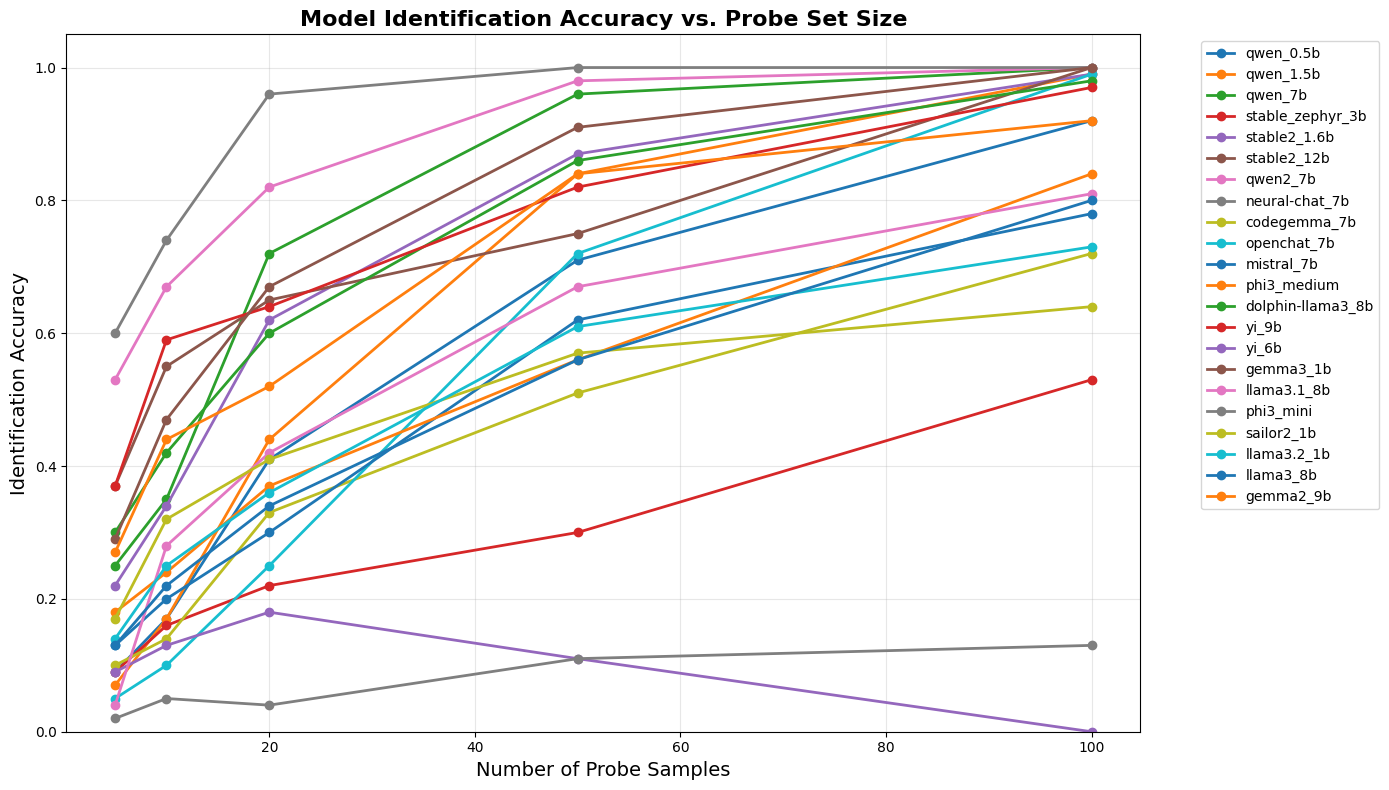

In [37]:
# Purpose: Plot identification accuracy as a function of probe size.

print("=" * 80)
print("VISUALIZING PROBE SIZE RESULTS")
print("=" * 80)

plt.figure(figsize=(14, 8))

for model_name, accs in results.items():
    plt.plot(probe_sizes, accs, marker='o', label=model_name,
             linewidth=2, markersize=6)

plt.xlabel('Number of Probe Samples', fontsize=14)
plt.ylabel('Identification Accuracy', fontsize=14)
plt.title('Model Identification Accuracy vs. Probe Set Size',
          fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig('probe_size_accuracy.png', dpi=150, bbox_inches='tight')
print("✓ Saved: probe_size_accuracy.png")
plt.show()

**Cell 14 – Performance vs. Identifiability Analysis**

Examines the relationship between task accuracy and fingerprint identifiability,

including correlation analysis to assess dependence.

IDENTIFICATION ACCURACY BY MODEL PERFORMANCE
✓ Saved: performance_vs_identifiability.png


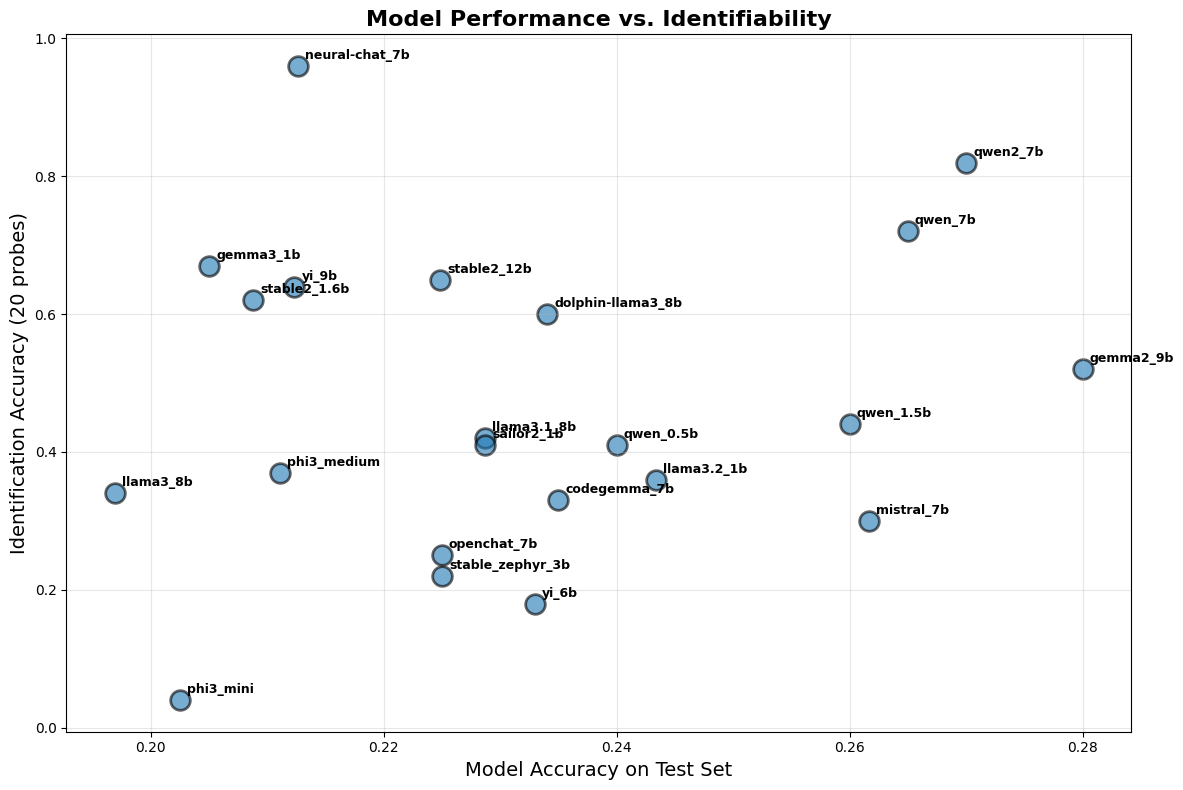


Correlation Analysis:
  Pearson correlation:  r=0.145, p=0.5191
  Spearman correlation: r=0.112, p=0.6209



In [38]:
# Purpose: Relate model accuracy to identifiability.

print("=" * 80)
print("IDENTIFICATION ACCURACY BY MODEL PERFORMANCE")
print("=" * 80)

# Get model accuracies

accuracies = {}
for name in model_names:
    col = model_pred_cols[name]
    test_pred = test_df[col].to_numpy()
    mask = (test_pred >= 0) & (test_pred < n_classes)

    if mask.sum() > 0:
        acc = (test_gold[mask] == test_pred[mask]).mean()
        accuracies[name] = acc

# Create scatter plot: model accuracy vs identification accuracy

acc_20 = [results[name][2] for name in model_names]  # 20-probe accuracy
model_accs = [accuracies[name] for name in model_names]

plt.figure(figsize=(12, 8))
plt.scatter(model_accs, acc_20, s=200, alpha=0.6, edgecolors='black', linewidth=2)

for i, name in enumerate(model_names):
    plt.annotate(name, (model_accs[i], acc_20[i]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9, fontweight='bold')

plt.xlabel('Model Accuracy on Test Set', fontsize=14)
plt.ylabel('Identification Accuracy (20 probes)', fontsize=14)
plt.title('Model Performance vs. Identifiability', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('performance_vs_identifiability.png', dpi=150, bbox_inches='tight')
print("✓ Saved: performance_vs_identifiability.png")
plt.show()

# Calculate correlation

from scipy.stats import pearsonr, spearmanr
pearson_r, pearson_p = pearsonr(model_accs, acc_20)
spearman_r, spearman_p = spearmanr(model_accs, acc_20)

print(f"\nCorrelation Analysis:")
print(f"  Pearson correlation:  r={pearson_r:.3f}, p={pearson_p:.4f}")
print(f"  Spearman correlation: r={spearman_r:.3f}, p={spearman_p:.4f}")
print()

**Cell 15 – Confusion Structure Analysis**

Analyzes off-diagonal confusion mass to quantify how dispersed each model’s error

distribution is, providing insight into fingerprint distinctiveness.

In [39]:
# Purpose: Compare models by distribution of systematic errors.

print("=" * 80)
print("CONFUSION MATRIX DISTANCE ANALYSIS")
print("=" * 80)

# Compute average off-diagonal mass (error distribution)

off_diag_mass = {}
for name in model_names:
    cm = conf_mats[name]
    cm_norm = cm / (cm.sum() + 1e-8)
    off_diag = cm_norm.sum() - cm_norm.diagonal().sum()
    off_diag_mass[name] = off_diag

# Sort models by error distribution

sorted_models = sorted(off_diag_mass.items(), key=lambda x: x[1], reverse=True)

print("\nModels by Error Distribution (off-diagonal mass):")
print(f"{'Model':<30s} {'Error Mass':<12s} {'Accuracy':<10s}")
print("-" * 52)
for name, mass in sorted_models:
    acc = accuracies.get(name, 0)
    print(f"{name:<30s} {mass:<12.4f} {acc:<10.3f}")

print()

CONFUSION MATRIX DISTANCE ANALYSIS

Models by Error Distribution (off-diagonal mass):
Model                          Error Mass   Accuracy  
----------------------------------------------------
mistral_7b                     0.7861       0.262     
gemma3_1b                      0.7825       0.205     
qwen_1.5b                      0.7822       0.260     
sailor2_1b                     0.7807       0.229     
llama3_8b                      0.7763       0.197     
llama3.2_1b                    0.7690       0.243     
stable2_1.6b                   0.7686       0.209     
phi3_mini                      0.7658       0.203     
gemma2_9b                      0.7604       0.280     
llama3.1_8b                    0.7601       0.229     
phi3_medium                    0.7574       0.211     
dolphin-llama3_8b              0.7572       0.234     
yi_9b                          0.7561       0.212     
yi_6b                          0.7510       0.233     
openchat_7b                    0.750

**Cell 16 – Summary Statistics**

Aggregates key performance and identification metrics into concise summaries,

highlighting best- and worst-case identifiability.

In [40]:
# Purpose: Summarize identification and performance results.

print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

print("\n📊 MODEL ACCURACIES:")
print(f"{'Model':<30s} {'Accuracy':<10s}")
print("-" * 40)
for name in sorted(accuracies.keys(), key=lambda x: accuracies[x], reverse=True):
    print(f"{name:<30s} {accuracies[name]:.3f}")

print("\n🎯 IDENTIFICATION PERFORMANCE:")
avg_acc_5 = np.mean([results[m][0] for m in model_names])
avg_acc_10 = np.mean([results[m][1] for m in model_names])
avg_acc_20 = np.mean([results[m][2] for m in model_names])
avg_acc_50 = np.mean([results[m][3] for m in model_names])
avg_acc_100 = np.mean([results[m][4] for m in model_names])

print(f"  With 5 probes:   {avg_acc_5:.3f} average accuracy")
print(f"  With 10 probes:  {avg_acc_10:.3f} average accuracy")
print(f"  With 20 probes:  {avg_acc_20:.3f} average accuracy")
print(f"  With 50 probes:  {avg_acc_50:.3f} average accuracy")
print(f"  With 100 probes: {avg_acc_100:.3f} average accuracy")

print("\n📈 BEST/WORST IDENTIFIABLE MODELS:")
id_20 = {name: results[name][2] for name in model_names}
sorted_id = sorted(id_20.items(), key=lambda x: x[1], reverse=True)

print(f"  Most identifiable:  {sorted_id[0][0]:30s} ({sorted_id[0][1]:.3f})")
print(f"  Least identifiable: {sorted_id[-1][0]:30s} ({sorted_id[-1][1]:.3f})")

print("\n" + "=" * 80)
print("✅ APPROACH 1 ANALYSIS COMPLETE")
print("=" * 80)

SUMMARY STATISTICS

📊 MODEL ACCURACIES:
Model                          Accuracy  
----------------------------------------
gemma2_9b                      0.280
qwen2_7b                       0.270
qwen_7b                        0.265
mistral_7b                     0.262
qwen_1.5b                      0.260
llama3.2_1b                    0.243
qwen_0.5b                      0.240
codegemma_7b                   0.235
dolphin-llama3_8b              0.234
yi_6b                          0.233
llama3.1_8b                    0.229
sailor2_1b                     0.229
stable_zephyr_3b               0.225
openchat_7b                    0.225
stable2_12b                    0.225
neural-chat_7b                 0.213
yi_9b                          0.212
phi3_medium                    0.211
stable2_1.6b                   0.209
gemma3_1b                      0.205
phi3_mini                      0.203
llama3_8b                      0.197

🎯 IDENTIFICATION PERFORMANCE:
  With 5 probes:   0.205 average

**Cell 17 – Export Results**

Persists all core metrics and identification results to disk to support reproducibility

and downstream analysis.

In [41]:
# Purpose: Persist summary metrics for downstream analysis.

# Create results summary dataframe

results_df = pd.DataFrame({
    'model': model_names,
    'accuracy': [accuracies.get(name, 0) for name in model_names],
    'id_5_probes': [results[name][0] for name in model_names],
    'id_10_probes': [results[name][1] for name in model_names],
    'id_20_probes': [results[name][2] for name in model_names],
    'id_50_probes': [results[name][3] for name in model_names],
    'id_100_probes': [results[name][4] for name in model_names],
    'off_diagonal_mass': [off_diag_mass[name] for name in model_names]
})

results_df = results_df.sort_values('accuracy', ascending=False)
results_df.to_csv('approach1_results.csv', index=False)
print("✓ Saved: approach1_results.csv")
print("\nResults DataFrame:")
print(results_df)

✓ Saved: approach1_results.csv

Results DataFrame:
                model  accuracy  id_5_probes  id_10_probes  id_20_probes  \
21          gemma2_9b  0.280000         0.27          0.44          0.52   
6            qwen2_7b  0.270000         0.53          0.67          0.82   
2             qwen_7b  0.265000         0.25          0.35          0.72   
10         mistral_7b  0.261628         0.13          0.20          0.30   
1           qwen_1.5b  0.260000         0.07          0.17          0.44   
19        llama3.2_1b  0.243386         0.14          0.25          0.36   
0           qwen_0.5b  0.240000         0.09          0.17          0.41   
8        codegemma_7b  0.235000         0.10          0.14          0.33   
12  dolphin-llama3_8b  0.234043         0.30          0.42          0.60   
14              yi_6b  0.232955         0.09          0.13          0.18   
18         sailor2_1b  0.228723         0.17          0.32          0.41   
16        llama3.1_8b  0.228723      